# k-nearest neighbors classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar_train = dict(npz_file.items())
print('It is a dictionary with keys:', list(cifar_train.keys()))
#cifar_train  

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar_train['overfeat']
y = cifar_train['labels']
names = cifar_train['names']
pixels = cifar_train['pixels'].astype(np.float32)
pixels = pixels / 255

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)
print('pixels:', pixels.shape, pixels.dtype)
print('names:', names)

X: (5000, 4096) float32
y: (5000,) int64
pixels: (5000, 3072) float32
names: ['truck' 'car' 'airplane' 'ship']


In [3]:
# Reshape images: 32 by 32 with 3 (RGB) color channels
pixels_reshaped = pixels.reshape(-1, 32, 32, 3)
print('pixels_reshaped:', pixels_reshaped.shape, pixels_reshaped.dtype)
#print(pixels_reshaped)

pixels_reshaped: (5000, 32, 32, 3) float32


# first task: 
Create a k-NN classifier with PCA. 
Tune k and the distance metric.

In [4]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te, Pix_tr, Pix_te = train_test_split(
    X, y, pixels, train_size=4000, test_size=1000, random_state=0, stratify=y)
print('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)
print('Pixels set:', Pix_tr.shape, Pix_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)
Pixels set: (4000, 3072) (1000, 3072)


In [5]:
# overfeat data: 176 values = 90% of the variance explained
from sklearn.preprocessing import StandardScaler
features=pd.DataFrame(X_tr) #convert to dataframe
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_rescaled = scaler.fit_transform(X_tr)

# Create PCA transformer
pca_n = PCA(n_components=176)  #176 Components for Sum-PVE= 0.9001692523306701
#pca_n = PCA(n_components=408) # 408 Components for Sum-PVE= 0.9500094570539659

# Apply PCA to rescaled data
X_2d_rescaled = pca_n.fit_transform(X_rescaled)
X_2d_rescaled_df=pd.DataFrame(X_2d_rescaled)
#print(X_2d_rescaled_df.head())

# Create DataFrame with variance and principal components
results_df2 = pd.DataFrame.from_dict([
    ('variance', X_rescaled.var(axis=0)),
    ('1st component', pca_n.components_[0]),
    ('2nd component', pca_n.components_[1]),
    ('3nd component', pca_n.components_[2])
])

# Sort DataFrame by the coefficients of the 1st loading vector
#results_df2.sort_values('1st component', ascending=False).head()

In [6]:
# Split data into train/validation sets
X_tr2, X_valid2, y_tr2, y_valid2 = train_test_split(
    X_2d_rescaled_df, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)
print('Train set:', X_tr2.shape, y_tr2.shape)
print('Sub set:', X_valid2.shape, y_valid2.shape)

Train set: (3200, 176) (3200,)
Sub set: (800, 176) (800,)


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create k-NN classifier
pipe = Pipeline([
    #('scaler', StandardScaler()), # With standardization
    ('scaler', None), # Better performance without standardization!
    ('knn', KNeighborsClassifier(
        algorithm='brute', # Brute-force search
        n_jobs=-1 # As many parallel jobs as possible
    ))
])

from sklearn.model_selection import ParameterGrid
# A first grid of parameters - start with a few k values
k_values = np.arange(15,55,5)
grid = ParameterGrid({
    'knn__n_neighbors': k_values, # k
    'knn__weights': ['uniform', 'distance'], # Weighting function
    'knn__p': [1, 2], # L1 and L2 distance metrics
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 32


In [8]:
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr2, y_tr2)

    # Save accuracy on test set
    params_dict['accuracy'] = pipe.score(X_valid2, y_valid2)
    print('  ','accuracy=', params_dict['accuracy'], '/ n_neighbors=',params_dict['knn__n_neighbors']) 

    # Save result
    test_scores.append(params_dict)

print('done')

Combination 1/32
   accuracy= 0.73875 / n_neighbors= 15
Combination 2/32
   accuracy= 0.75 / n_neighbors= 15
Combination 3/32
   accuracy= 0.765 / n_neighbors= 15
Combination 4/32
   accuracy= 0.76875 / n_neighbors= 15
Combination 5/32
   accuracy= 0.74875 / n_neighbors= 20
Combination 6/32
   accuracy= 0.75375 / n_neighbors= 20
Combination 7/32
   accuracy= 0.77125 / n_neighbors= 20
Combination 8/32
   accuracy= 0.7675 / n_neighbors= 20
Combination 9/32
   accuracy= 0.74875 / n_neighbors= 25
Combination 10/32
   accuracy= 0.755 / n_neighbors= 25
Combination 11/32
   accuracy= 0.76375 / n_neighbors= 25
Combination 12/32
   accuracy= 0.76375 / n_neighbors= 25
Combination 13/32
   accuracy= 0.75375 / n_neighbors= 30
Combination 14/32
   accuracy= 0.7575 / n_neighbors= 30
Combination 15/32
   accuracy= 0.77 / n_neighbors= 30
Combination 16/32
   accuracy= 0.77375 / n_neighbors= 30
Combination 17/32
   accuracy= 0.755 / n_neighbors= 35
Combination 18/32
   accuracy= 0.7575 / n_neighbors= 3

In [9]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

# Print scores
scores_df.sort_values(by='accuracy', ascending=False)
df1=scores_df.sort_values(by='accuracy', ascending=False)
#test_scores_df=scores_df.sort_values(by='accuracy', ascending=False)
print(df1.head(9))
#test_scores_df

    accuracy  knn__n_neighbors  knn__p knn__weights
31   0.77875                50       2     distance
23   0.77750                40       2     distance
30   0.77625                50       2      uniform
19   0.77375                35       2     distance
15   0.77375                30       2     distance
6    0.77125                20       2      uniform
18   0.77125                35       2      uniform
22   0.77125                40       2      uniform
26   0.77125                45       2      uniform


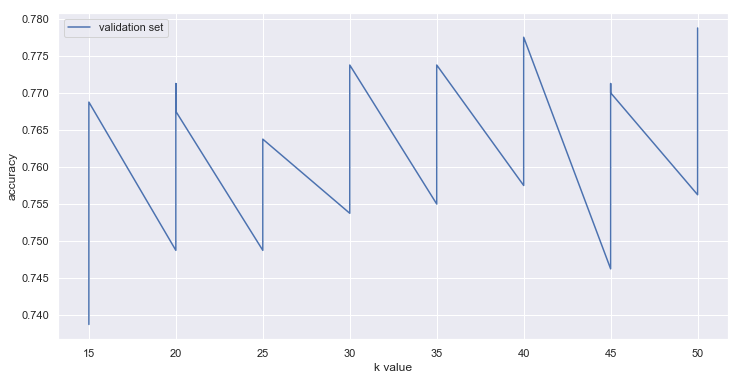

In [10]:
# Plot test curve
plt.figure( figsize=(12, 6))
plt.plot(scores_df.knn__n_neighbors, scores_df.accuracy, label='validation set')
plt.xlabel('k value')
plt.ylabel('accuracy')
# x-ticks  for single k values
#plt.xticks(k_values[::1], k_values[::1])
plt.legend()
plt.show()

In [11]:
## Refine our search
# Refine the grid
k_values = np.arange(15, 46) # Define k values
grid = ParameterGrid({
    'knn__n_neighbors': k_values, # k
    'knn__weights': ['distance'], # Weighting function
    'knn__p': [2], # L2  distance metrics
})

# Grid search
test_scores = []

for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)  

    # Fit a k-NN classifier
    pipe.fit(X_tr2, y_tr2)

    # Save accuracy on test set
    params_dict['accuracy'] = pipe.score(X_valid2, y_valid2)
    print('  ','accuracy=', params_dict['accuracy'], '/ n_neighbors=',params_dict['knn__n_neighbors']) 

    # Save result
    test_scores.append(params_dict)

print('done')

# Create DataFrame with scores
test_scores_df=pd.DataFrame(test_scores)
#print(test_scores_df)

Combination 1/31
   accuracy= 0.76875 / n_neighbors= 15
Combination 2/31
   accuracy= 0.76625 / n_neighbors= 16
Combination 3/31
   accuracy= 0.7725 / n_neighbors= 17
Combination 4/31
   accuracy= 0.76875 / n_neighbors= 18
Combination 5/31
   accuracy= 0.77375 / n_neighbors= 19
Combination 6/31
   accuracy= 0.7675 / n_neighbors= 20
Combination 7/31
   accuracy= 0.77125 / n_neighbors= 21
Combination 8/31
   accuracy= 0.7725 / n_neighbors= 22
Combination 9/31
   accuracy= 0.77 / n_neighbors= 23
Combination 10/31
   accuracy= 0.77 / n_neighbors= 24
Combination 11/31
   accuracy= 0.76375 / n_neighbors= 25
Combination 12/31
   accuracy= 0.76375 / n_neighbors= 26
Combination 13/31
   accuracy= 0.77 / n_neighbors= 27
Combination 14/31
   accuracy= 0.77 / n_neighbors= 28
Combination 15/31
   accuracy= 0.76625 / n_neighbors= 29
Combination 16/31
   accuracy= 0.77375 / n_neighbors= 30
Combination 17/31
   accuracy= 0.76875 / n_neighbors= 31
Combination 18/31
   accuracy= 0.76625 / n_neighbors= 3

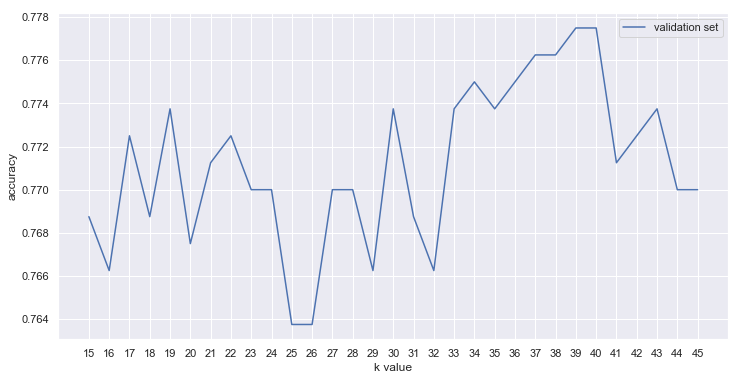

In [12]:
# Plot test curve
plt.figure( figsize=(12, 6))
plt.plot(k_values, test_scores_df.accuracy, label='validation set')
plt.xlabel('k value')
plt.ylabel('accuracy')
# x-ticks  for single k values
plt.xticks(k_values[::1], k_values[::1])
plt.legend()
plt.show()

In [13]:
# Print k with maximum accuracy
#print(test_scores_df)
idx = test_scores_df.accuracy.idxmax() # Index of maximum value
max_accuracy = test_scores_df.accuracy[idx]
best_k = k_values[idx]
print('Top accuracy on validation set: accuracy= {:.3f} with k={} and distance metric: uniform'
      .format(max_accuracy, best_k, df1.knn__weights))

Top accuracy on validation set: accuracy= 0.777 with k=39 and distance metric: uniform


In [14]:
## Finally, fit the tuned parameters to the entire train data with the 4,000 data points 
# Refine the grid
k_values = np.arange(15, 41) # Define k values
grid = ParameterGrid({
    'knn__n_neighbors': k_values, # k
    'knn__weights': ['distance'], # Weighting function
    'knn__p': [2], # L2  distance metrics
})

# Grid search
test_scores = []

for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)  

    # Fit a k-NN classifier
    pipe.fit(X_tr, y_tr)

    # Save accuracy on test set
    params_dict['accuracy'] = pipe.score(X_te, y_te)
    print('  ','accuracy=', params_dict['accuracy'], '/ n_neighbors=',params_dict['knn__n_neighbors']) 

    # Save result
    test_scores.append(params_dict)

print('done')

# Create DataFrame with scores
test_scores_df=pd.DataFrame(test_scores)
#print(test_scores_df)

Combination 1/26
   accuracy= 0.786 / n_neighbors= 15
Combination 2/26
   accuracy= 0.785 / n_neighbors= 16
Combination 3/26
   accuracy= 0.792 / n_neighbors= 17
Combination 4/26
   accuracy= 0.794 / n_neighbors= 18
Combination 5/26
   accuracy= 0.781 / n_neighbors= 19
Combination 6/26
   accuracy= 0.786 / n_neighbors= 20
Combination 7/26
   accuracy= 0.784 / n_neighbors= 21
Combination 8/26
   accuracy= 0.785 / n_neighbors= 22
Combination 9/26
   accuracy= 0.784 / n_neighbors= 23
Combination 10/26
   accuracy= 0.773 / n_neighbors= 24
Combination 11/26
   accuracy= 0.784 / n_neighbors= 25
Combination 12/26
   accuracy= 0.778 / n_neighbors= 26
Combination 13/26
   accuracy= 0.784 / n_neighbors= 27
Combination 14/26
   accuracy= 0.786 / n_neighbors= 28
Combination 15/26
   accuracy= 0.783 / n_neighbors= 29
Combination 16/26
   accuracy= 0.782 / n_neighbors= 30
Combination 17/26
   accuracy= 0.783 / n_neighbors= 31
Combination 18/26
   accuracy= 0.783 / n_neighbors= 32
Combination 19/26
 

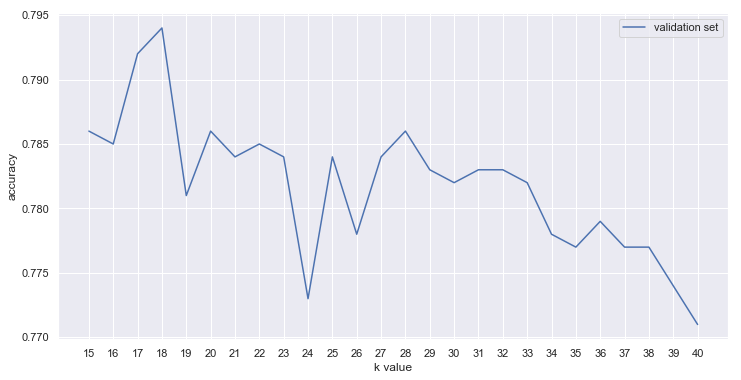

In [15]:
# Plot test curve
plt.figure( figsize=(12, 6))
plt.plot(k_values, test_scores_df.accuracy, label='validation set')
plt.xlabel('k value')
plt.ylabel('accuracy')
# x-ticks  for single k values
plt.xticks(k_values[::1], k_values[::1])
plt.legend()
plt.show()

In [16]:
# Print k with maximum accuracy
#print(test_scores_df)
idx = test_scores_df.accuracy.idxmax() # Index of maximum value
max_accuracy = test_scores_df.accuracy[idx]
best_k = k_values[idx]
print('Top accuracy on test set: accuracy= {:.3f} with k={} and distance metric: distance'
      .format(max_accuracy, best_k))

Top accuracy on test set: accuracy= 0.794 with k=18 and distance metric: distance


In [17]:
# Load data
import pandas as pd
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.797
4        svm rbf          0.842
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816


In [18]:
Result_df.iloc[0,1]=max_accuracy
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.797
4        svm rbf          0.842
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816


In [19]:
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')

# Task 2: 
Choose an image from the test set and plot its 10 nearest neighbors.

In [20]:
Pix_reshaped=pixels.reshape(-1, 32, 32, 3)
print('pixels_reshaped:', Pix_reshaped.shape, Pix_reshaped.dtype)

pixels_reshaped: (5000, 32, 32, 3) float32


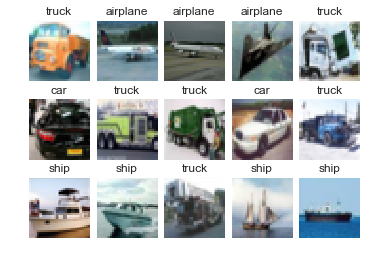

In [21]:
#plot random images to check images vs. labels
import random
count_pics=0
plt.subplots_adjust(wspace=0.05, hspace=0.3) 
while count_pics < 15:   
    mix=random.randint(1,999)
    plt.subplot(3, 5, count_pics+1)
    plt.imshow(Pix_reshaped[mix,:,:,:], cmap='gnuplot2')
    plt.title("{}".format(names[y[mix]]), fontsize=12)
    plt.axis('off')
    count_pics=count_pics+1 

In [22]:
Pix_tr_reshaped=Pix_tr.reshape(-1, 32, 32, 3)
#print('pixels_reshaped:', Pix_tr_reshaped.shape, Pix_tr_reshaped.dtype)

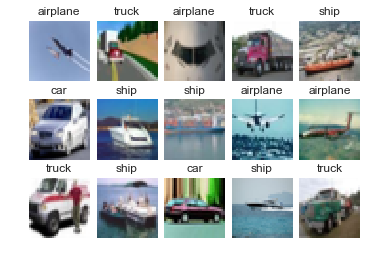

In [23]:
#plot random images of Training data to check images vs. labels
import random
count_pics=0
plt.subplots_adjust(wspace=0.05, hspace=0.3) 
while count_pics < 15:   
    mix=random.randint(1,999)
    plt.subplot(3, 5, count_pics+1)
    plt.imshow(Pix_tr_reshaped[mix,:,:,:], cmap='gnuplot2')
    plt.title("{}".format(names[y_tr[mix]]), fontsize=12)
    plt.axis('off')
    count_pics=count_pics+1 

In [24]:
Pix_te_reshaped=Pix_te.reshape(-1, 32, 32, 3)
#print('pixels_reshaped:', Pix_tr_reshaped.shape, Pix_tr_reshaped.dtype)

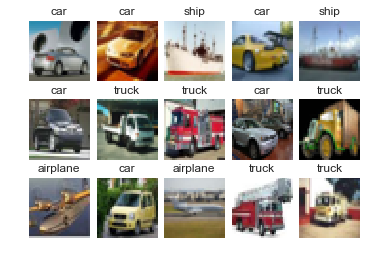

In [25]:
#plot random images of Testing data
import random
count_pics=0
plt.subplots_adjust(wspace=0.05, hspace=0.3) 
while count_pics < 15:   
    mix=random.randint(1,999)
    plt.subplot(3, 5, count_pics+1)
    plt.imshow(Pix_te_reshaped[mix,:,:,:], cmap='gnuplot2')
    plt.title("{}".format(names[y_te[mix]]), fontsize=12)
    plt.axis('off')
    count_pics=count_pics+1 

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=18,weights = 'uniform',algorithm='brute',p=2, n_jobs=-1)
knn.fit(X_tr, y_tr)
print("Test set score: {:.2f}".format(knn.score(X_te, y_te)))

Test set score: 0.78


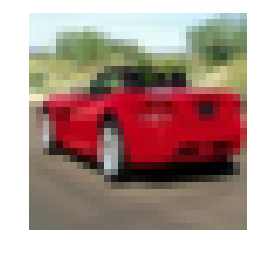

In [27]:
#Choose a test image: for example the second image of the test data
Num_Image=11 #11 from X-te/ 3 from X_tr =red car
X_test_image = X_te[Num_Image]
X_test_image = X_test_image.reshape(1, -1)
plt.imshow(Pix_te_reshaped[Num_Image],cmap='gnuplot2')
plt.axis('off')
plt.show()

In [28]:
#Following PCA fit does not work
#pca = PCA(n_components=204, whiten=True, random_state=0).fit(X_tr)
#X_tr_pca = pca.transform(X_tr)
#X_test_image_pca = pca.transform(X_test_image)
#print("X_train_pca.shape: {}".format(X_tr_pca.shape))
#print("X_train_pca.shape: {}".format(X_test_image_pca.shape))

In [29]:
knn = KNeighborsClassifier(n_neighbors=6,weights = 'uniform',algorithm='brute',p=2, n_jobs=-1)
knn.fit(X_tr, y_tr)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
           weights='uniform')

In [ ]:
#search for kneighbors
from sklearn.neighbors import NearestNeighbors
distances, indices = knn.kneighbors(X_test_image , 10)
print('distances:',distances)
print()
print('indices:', indices)

In [52]:
distances_df=pd.DataFrame(distances)
distances_df=distances_df.round(2)
print(distances_df)

indices_df=pd.DataFrame(indices)
print(indices_df)

       0      1      2      3      4      5      6      7      8      9
0  61.76  62.75  63.03  63.04  63.11  63.64  63.68  63.72  63.82  63.86
      0     1    2     3    4     5    6     7     8     9
0  1151  3841  320  3313  400  3050  157  2274  2014  1703


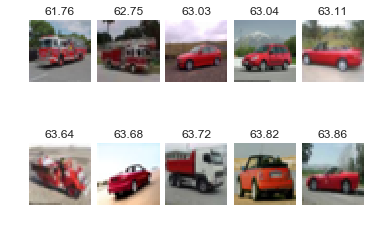

In [55]:
#Show ten neighbors images
def draw_samples_Serie10(indices_df):       
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  
    
    for i in range(0, 10):        
        #print(indices_df.values[0,i])
        plt.subplot(2,5, i+1)        
        img = Pix_tr_reshaped[indices_df.values[0,i],:,:,:]          
        plt.imshow(img, cmap='gnuplot2')    
        plt.title(distances_df.values[0,i], fontsize=12)
        plt.axis('off')        

draw_samples_Serie10(indices_df)